# PPMI

In [2]:
library(dplyr)
library(data.table)
# Inverse normal transoformation
invNT=function(x){ 
  qnorm((rank(x,na.last="keep")-0.5)/sum(!is.na(x))) 
}
options("width"=130)
library(lme4)

In [3]:
csf = fread("../PDcohorts/PPMI/PPMI180927/Current_Biospecimen_Analysis_Results.csv", colClasses = c("PATNO"="character")) %>% 
    filter(grepl("CSF", TESTNAME)) %>% select(PATNO, TESTNAME, TESTVALUE, CLINICAL_EVENT)
csf_asyn = csf %>% filter(TESTNAME == "CSF Alpha-synuclein") %>% rename(ASYN=TESTVALUE, EVENT_ID = CLINICAL_EVENT) %>%
    select(PATNO, EVENT_ID, ASYN)
csf_hemo = csf %>% filter(TESTNAME == "CSF Hemoglobin") %>% rename(HEMO=TESTVALUE, EVENT_ID = CLINICAL_EVENT) %>%
    select(PATNO, EVENT_ID, HEMO)
csf = inner_join(csf_asyn, csf_hemo, by = c("PATNO", "EVENT_ID"))

No numeric number

Warning message in evalq(is.na(as.numeric(HEMO)), <environment>):
"NAs introduced by coercion"

[1] "below" "above" "N/A"

Warning message in evalq(is.na(as.numeric(ASYN)), <environment>):
"NAs introduced by coercion"

[1] "N/A"

Exclude obs with 'N/A' and 'above'. 'below' is given value 10

Warning message in eval_bare(f[[3]], env):
"NAs introduced by coercion"

    PATNO             EVENT_ID              HEMO            rawASYN          logASYN         ivnASYN       
 Length:2922        Length:2922        Min.   :  10.00   Min.   : 235.8   Min.   :5.463   Min.   :-3.5810  
 Class :character   Class :character   1st Qu.:  10.00   1st Qu.:1051.4   1st Qu.:6.958   1st Qu.:-0.6734  
 Mode  :character   Mode  :character   Median :  10.00   Median :1408.2   Median :7.250   Median : 0.0000  
                                       Mean   :  70.59   Mean   :1520.3   Mean   :7.239   Mean   : 0.0000  
                                       3rd Qu.:  45.15   3rd Qu.:1825.0   3rd Qu.:7.509   3rd Qu.: 0.6741  
                                       Max.   :1227.30   Max.   :5256.9   Max.   :8.567   Max.   : 3.5810  

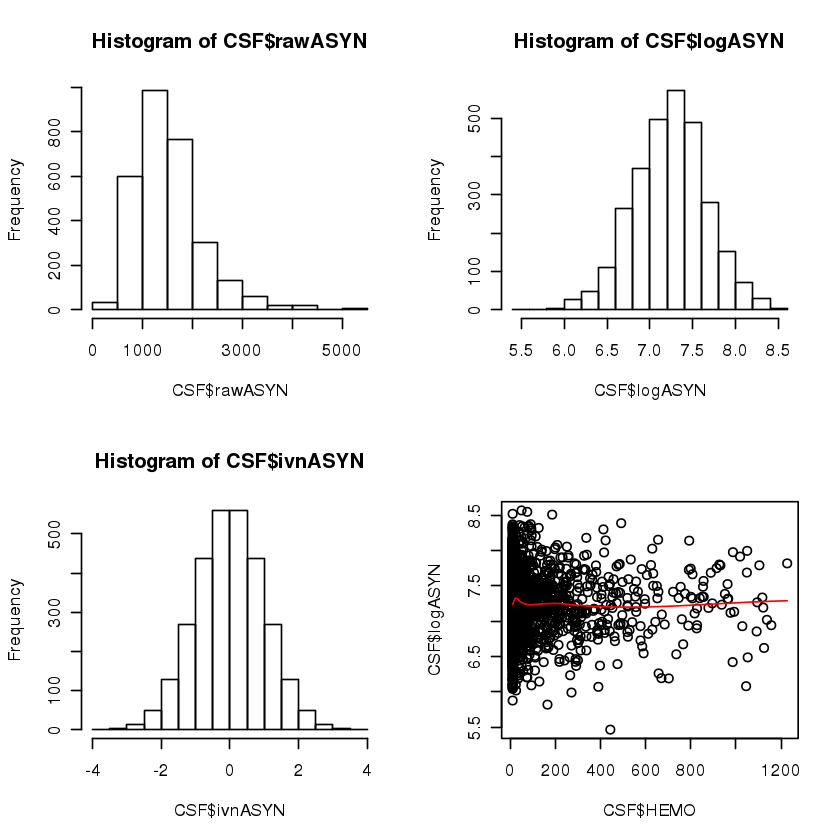

In [4]:
cat("No numeric number")
csf %>% filter(is.na(as.numeric(HEMO))) %>% distinct(HEMO) %>% t %>% as.vector
csf %>% filter(is.na(as.numeric(ASYN))) %>% distinct(ASYN) %>% t %>% as.vector
cat("Exclude obs with 'N/A' and 'above'. 'below' is given value 10")
CSF = csf %>% na_if("N/A") %>% na_if('above') %>% filter(complete.cases(.)) %>%
    mutate(HEMO = case_when(
    HEMO=="below"~ 10,
    TRUE~ as.numeric(HEMO))) %>% 
    mutate(rawASYN = as.numeric(ASYN)) %>%
    mutate(logASYN = log(rawASYN), ivnASYN=invNT(rawASYN)) %>% select(-ASYN)
summary(CSF)
par(mfrow=c(2,2))
hist(CSF$rawASYN);hist(CSF$logASYN);hist(CSF$ivnASYN)
CSF1 = CSF %>% arrange(HEMO)
plot(CSF$HEMO, CSF$logASYN);plx = predict(loess(CSF1$logASYN~CSF1$HEMO), se=T);lines(CSF1$HEMO, plx$fit, col="red")

[1] "ID"             "CASE"           "FEMALE"         "AAO"            "YEARSEDUC"      "FAMILY_HISTORY" "DIAG"          
 [8] "EVENT_ID"       "HEMO"           "rawASYN"        "logASYN"        "ivnASYN"        "AGE"

N of observaation: CASE==0, Control in PPMI; 1, CASEs in PPMI; 99, Others.

CASE
  0   1  99 
181 401 317 

Diagnosis category with more than 10 people.


                      
DIAG                   TRUE
  In__CTR_YsImg_LRRK2+   38
  In__PRD_YsImg_HYP      10
  In__PRD_YsImg_LRRK2+   16
  In__PRD_YsImg_RBD      23
  In__iPD_SWEDD_PPMI     46
  In__iPD_YsImg_LRRK2+   67

Recode CASE;
If DIAG==In__iPD_YsImg_LRRK2+, then CASE = 1.1
If DIAG==In__iPD_SWEDD_PPMI, then CASE = 0.1
If DIAG==In__PRD_YsImg*, then CASE = 2.0
Then see the baseline ASYN

Warning message in min(x, na.rm = TRUE):
"no non-missing arguments to min; returning Inf"Warning message in max(x, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"Warning message in min(x, na.rm = TRUE):
"no non-missing arguments to min; returning Inf"Warning message in max(x, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"Warning message in StdDiff(variable = var, group = strataVar):
"Variable has only NA's in at least one stratum. na.rm turned off."

                            Stratified by CASE
                             0                0.1              1                1.1              2                p      test
  n                              178               40              392               63               46                     
  FEMALE (mean (sd))            0.38 (0.49)      0.42 (0.50)      0.36 (0.48)      0.48 (0.50)      0.46 (0.50)    0.339     
  AAO (mean (sd))                NaN (NA)       59.75 (10.43)    60.97 (9.46)     58.55 (9.84)       NaN (NA)      0.160     
  YEARSEDUC (mean (sd))        16.25 (3.00)     15.03 (3.81)     15.73 (2.97)     15.35 (4.59)     13.22 (4.52)   <0.001     
  FAMILY_HISTORY (mean (sd))    0.00 (0.00)      0.20 (0.41)      0.13 (0.33)      0.46 (0.50)      0.30 (0.47)   <0.001     
  EVENT_ID = BL (%)              178 (100.0)       40 (100.0)      392 (100.0)       63 (100.0)       46 (100.0)   NA        
  HEMO (mean (sd))             73.11 (165.20)   74.00 (181.04)   73.91 

Combine CASE 0.1 -> 0, CASE 1.1 -> 1.0, CASE 2.0 will be excluded.
Show the BL comparison again

Warning message in min(x, na.rm = TRUE):
"no non-missing arguments to min; returning Inf"Warning message in max(x, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"Warning message in StdDiff(variable = var, group = strataVar):
"Variable has only NA's in at least one stratum. na.rm turned off."

                            Stratified by CASE
                             0                1                p      test
  n                              218              455                     
  FEMALE (mean (sd))            0.39 (0.49)      0.38 (0.48)    0.725     
  AAO (mean (sd))                NaN (NA)       60.64 (9.54)    NA        
  YEARSEDUC (mean (sd))        16.03 (3.19)     15.68 (3.24)    0.187     
  FAMILY_HISTORY (mean (sd))    0.04 (0.19)      0.17 (0.38)   <0.001     
  EVENT_ID = BL (%)              218 (100.0)      455 (100.0)   NA        
  HEMO (mean (sd))             73.27 (167.78)   78.96 (160.88)  0.672     
  rawASYN (mean (sd))        1642.55 (712.34) 1477.66 (653.46)  0.003     
  logASYN (mean (sd))           7.31 (0.43)      7.22 (0.40)    0.004     
  ivnASYN (mean (sd))           0.18 (1.02)     -0.06 (0.96)    0.003     
  AGE (mean (sd))              60.71 (11.08)    61.54 (9.47)    0.313     

Data summary

     IID                 CASE            FEMALE            AAO          YEARSEDUC     FAMILY_HISTORY        DIAG          
 Length:2121        Min.   :0.0000   Min.   :0.0000   Min.   :33.42   Min.   : 5.00   Min.   :0.00000   Length:2121       
 Class :character   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:54.54   1st Qu.:14.00   1st Qu.:0.00000   Class :character  
 Mode  :character   Median :1.0000   Median :0.0000   Median :61.75   Median :16.00   Median :0.00000   Mode  :character  
                    Mean   :0.6587   Mean   :0.3451   Mean   :61.34   Mean   :16.06   Mean   :0.09821                     
                    3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:68.33   3rd Qu.:18.00   3rd Qu.:0.00000                     
                    Max.   :1.0000   Max.   :1.0000   Max.   :84.75   Max.   :26.00   Max.   :1.00000                     
                                                      NA's   :726                     NA's   :3                           
    EVENT_ID    


Pheno type file for PPMI saved
boxplot indicates no clear longitudinal effects


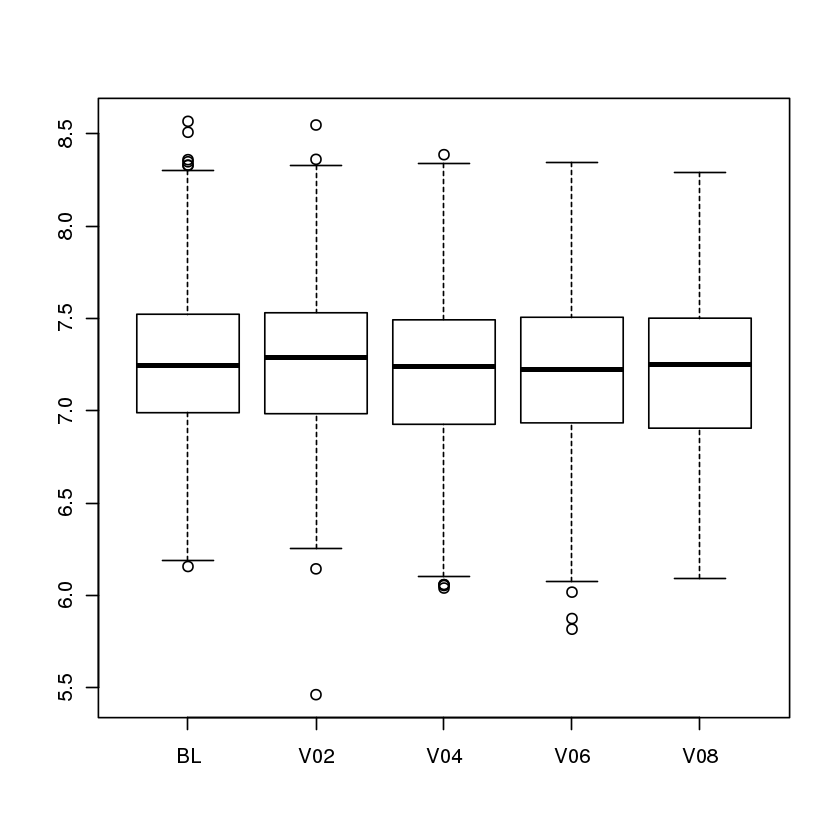

In [5]:
t1 = fread("data/02_LatestDiagDemog.csv", header=T) %>% 
  mutate(CASE = case_when(
    grepl("PD_YsImg_PPMI", DIAG) ~ 1, 
    grepl("CTR_YsImg_PPMI", DIAG) ~ 0,
    TRUE~ 99)) %>%
  mutate(AAO = (DIAGDATE - BIRTHDT)/365.25) %>%
  select(ID, CASE, FEMALE, AAO, YEARSEDUC, FAMILY_HISTORY, DIAG, BIRTHDT) 
d1 = inner_join(t1, CSF, by = c("ID"="PATNO")) %>% 
    inner_join(., fread("data/PATNO_EVENTID_DATE.csv", header = T, colClasses = c("PATNO"="character")),
                by =c("ID"="PATNO", "EVENT_ID")) %>%
    mutate(AGE = (DATE - BIRTHDT)/365.25) %>% 
    select(-BIRTHDT) %>% select(-DATE)
names(d1)
cat("N of observaation: CASE==0, Control in PPMI; 1, CASEs in PPMI; 99, Others.")
d1 %>% distinct(ID, .keep_all = T) %>% with(table(CASE))
cat("Diagnosis category with more than 10 people.\n")
d1 %>% filter(CASE==99) %>% distinct(ID, .keep_all = T) %>% group_by(DIAG) %>% mutate(N10=n()) %>%
    filter(N10>=10) %>% ungroup %>%with(table(DIAG, !is.na(DIAG)))
library(tableone)
cat("Recode CASE;
If DIAG==In__iPD_YsImg_LRRK2+, then CASE = 1.1
If DIAG==In__iPD_SWEDD_PPMI, then CASE = 0.1
If DIAG==In__PRD_YsImg*, then CASE = 2.0
Then see the baseline ASYN")
d2 = d1 %>% 
    mutate(CASE=ifelse(DIAG=="In__iPD_YsImg_LRRK2+", 1.1, CASE)) %>%
    mutate(CASE=ifelse(DIAG=="In__iPD_SWEDD_PPMI", 0.1, CASE)) %>% 
    mutate(CASE=ifelse(grepl("In__PRD_YsImg", DIAG), 2, CASE)) %>% 
    filter(CASE!=99)
d2 %>% filter(EVENT_ID=="BL") %>%
    CreateTableOne(vars=names(d1)[-c(1,2,7)], data=., strata="CASE")
d3 = d2 %>% mutate(CASE=floor(CASE)) %>% filter(CASE!=2) %>% rename(IID =ID) %>%
    mutate(IID = paste(IID, IID, sep="_")) %>%
    mutate(AAO = if_else(CASE==1, AAO, NA_real_))
cat("Combine CASE 0.1 -> 0, CASE 1.1 -> 1.0, CASE 2.0 will be excluded.
Show the BL comparison again")
d3 %>% filter(EVENT_ID=="BL") %>%
    CreateTableOne(vars=names(d1)[-c(1,2,7)], data=., strata="CASE")
d3 = d3 %>% inner_join(., fread("../dataset//PPMI/pca10.txt", header = T), by ="IID") %>% select (-FID)
cat("Data summary")
d3 %>% mutate(EVENT_ID=as.factor(EVENT_ID)) %>% summary
cat("\nPheno type file for PPMI saved\n")
dir.create("dataset/PPMI/pheno", recursive = T, showWarnings = F)
d3 %>%
    write.table(., "dataset/PPMI/pheno/all.txt", row.names = F, quote = F, sep = "\t")
d3 %>% filter(CASE==0) %>% 
    write.table(., "dataset/PPMI/pheno/control.txt", row.names = F, quote = F, sep = "\t")
d3 %>% filter(CASE==1) %>% 
    write.table(., "dataset/PPMI/pheno/case.txt", row.names = F, quote = F, sep = "\t")

cat("boxplot indicates no clear longitudinal effects\n")
d3 %>% mutate(EVENT_ID=factor(EVENT_ID, levels=c("BL", "V02", "V04", "V06", "V08"))) %>% with(boxplot(logASYN~EVENT_ID))


In [6]:
cat("Model building")
full =  d3 %>% filter(CASE==1) %>% 
    lmer(logASYN~HEMO+FEMALE+YEARSEDUC+AAO+FAMILY_HISTORY + AGE +(1|IID), data=., REML=F)
# summary(full)
full_mYEARSEDUCmFH =  d3 %>% filter(CASE==1) %>% filter(!is.na(FAMILY_HISTORY)) %>%
    lmer(logASYN~HEMO+FEMALE+AAO + AGE +(1|IID), data=., REML=F)
# summary(full_mYEARSEDUCmFH)
full_mYEARSEDUCmFHmAGE =  d3 %>% filter(CASE==1) %>% filter(!is.na(FAMILY_HISTORY)) %>%
    lmer(logASYN~HEMO+FEMALE+ AAO + (1|IID), data=., REML=F)
full_mYEARSEDUCmFHmAAO = d3 %>% filter(CASE==1) %>% filter(!is.na(AAO)) %>% filter(!is.na(FAMILY_HISTORY)) %>%
    lmer(logASYN~HEMO+FEMALE+AGE + (1|IID), data=., REML=F)
AIC(full, full_mYEARSEDUCmFH, full_mYEARSEDUCmFHmAGE, full_mYEARSEDUCmFHmAAO)

# summary(full)
full_mYEARSEDUCmFH =  d3 %>% filter(CASE==1) %>%
    lmer(logASYN~HEMO+FEMALE+AAO + AGE +(1|IID), data=., REML=F)
# summary(full_mYEARSEDUCmFH)
full_mYEARSEDUCmFHmAGE =  d3 %>% filter(CASE==1) %>% 
    lmer(logASYN~HEMO+FEMALE+ AAO + (1|IID), data=., REML=F)

anova(full_mYEARSEDUCmFH, full_mYEARSEDUCmFHmAGE)
cat("final model== lmer(logASYN~HEMO+FEMALE+AAO + AGE +(1|IID))")

Model building

,df,AIC
full,9,182.1601
full_mYEARSEDUCmFH,7,178.2840
full_mYEARSEDUCmFHmAGE,6,180.2287
full_mYEARSEDUCmFHmAAO,6,184.6067


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
full_mYEARSEDUCmFHmAGE,6,189.3766,220.8205,-88.68830,177.3766,NA,NA,NA
full_mYEARSEDUCmFH,7,186.7347,223.4192,-86.36733,172.7347,4.641938,1,0.03119976


final model== lmer(logASYN~HEMO+FEMALE+AAO + AGE +(1|IID))

In [7]:
summary(full_mYEARSEDUCmFH)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: logASYN ~ HEMO + FEMALE + AAO + AGE + (1 | IID)
   Data: .

     AIC      BIC   logLik deviance df.resid 
   186.7    223.4    -86.4    172.7     1388 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.6269 -0.4242  0.0446  0.4726  4.7592 

Random effects:
 Groups   Name        Variance Std.Dev.
 IID      (Intercept) 0.13287  0.3645  
 Residual             0.03428  0.1852  
Number of obs: 1395, groups:  IID, 342

Fixed effects:
              Estimate Std. Error t value
(Intercept)  6.831e+00  1.368e-01  49.927
HEMO         5.188e-05  4.003e-05   1.296
FEMALE       7.758e-02  4.350e-02   1.784
AAO          1.649e-02  5.426e-03   3.040
AGE         -1.073e-02  4.975e-03  -2.157

Correlation of Fixed Effects:
       (Intr) HEMO   FEMALE AAO   
HEMO   -0.001                     
FEMALE -0.179  0.003              
AAO    -0.338 -0.043  0.032       
AGE    -0.059  0.037 -0.003 -0.917

# ADNI

In [3]:
df=fread("../ADNI/180831/PTDEMOG.csv")
df1 = df %>% mutate(
  DATE = as.Date(USERDATE) %>% as.numeric, # 0 == "1970-1-1" 
  DOB = paste(PTDOBYY,PTDOBMM,"01", sep="-") %>% as.Date %>% as.numeric,
  YEARSEDUC=PTEDUCAT,
  FEMALE=I(PTGENDER==2)*1) %>% 
  select(Phase, ID, RID, SITEID, VISCODE, FEMALE, DATE, DOB, YEARSEDUC)
cat("Summary of DEMOGRAPHIC DATA. Longitudinally recoreded. DATE and DOB are counterd from 1970-01-01")
df1 %>% summary
#  df1 %>% filter(DOB>0) # Too young. Exclude these people
df2 = df1 %>% filter(DOB<0)
#  df2 %>% filter(YEARSEDUC<0) # some has '-1' . should be missing indicator/second observation indicator. Exclude
df3 = df2 %>% filter(YEARSEDUC>0)
cat("After exclude DOB>0 and YEARSEDUC<0, No NA observations")
df3 %>% summary
# The below line shows the inconsistent results across longitudinal observations. These should be individually checked. 
#  df3 %>% group_by(RID) %>% mutate_at(vars(names(df3)[c(6,8,9)]), funs( (. - first(.))^2)) %>% data.frame %>% mutate( INDICATOR = rowSums(.[,c(6,8,9)], na.rm=T)) %>%  filter(INDICATOR>0)
# Taking the value at the first observation seems OK.
df4 = df3 %>% arrange(DATE) %>% distinct(RID, .keep_all = T)
DEMO = df4 %>% select(RID, FEMALE, DOB, YEARSEDUC)

Summary of DEMOGRAPHIC DATA. Longitudinally recoreded. DATE and DOB are counterd from 1970-01-01

    Phase                 ID             RID             SITEID      
 Length:4294        Min.   :   12   Min.   :   1.0   Min.   :  1.00  
 Class :character   1st Qu.:  748   1st Qu.: 753.2   1st Qu.: 15.00  
 Mode  :character   Median : 1515   Median :2107.5   Median : 33.00  
                    Mean   : 5554   Mean   :2729.6   Mean   : 39.80  
                    3rd Qu.: 2596   3rd Qu.:4744.8   3rd Qu.: 50.75  
                    Max.   :60343   Max.   :6577.0   Max.   :127.00  
                                                                     
   VISCODE              FEMALE            DATE            DOB        
 Length:4294        Min.   :0.0000   Min.   :13012   Min.   :-19755  
 Class :character   1st Qu.:0.0000   1st Qu.:13473   1st Qu.:-14520  
 Mode  :character   Median :0.0000   Median :15146   Median :-12328  
                    Mean   :0.4604   Mean   :14958   Mean   :-11941  
                    3rd Qu.:1.0000   3rd Qu.:15538   3rd Qu.: -9437  
                    

After exclude DOB>0 and YEARSEDUC<0, No NA observations

    Phase                 ID               RID             SITEID      
 Length:4104        Min.   :   12.0   Min.   :   1.0   Min.   :  1.00  
 Class :character   1st Qu.:  737.5   1st Qu.: 780.8   1st Qu.: 15.00  
 Mode  :character   Median : 1511.0   Median :2158.5   Median : 33.00  
                    Mean   : 5648.6   Mean   :2790.4   Mean   : 39.81  
                    3rd Qu.: 2552.0   3rd Qu.:4780.5   3rd Qu.: 51.00  
                    Max.   :60343.0   Max.   :6577.0   Max.   :127.00  
   VISCODE              FEMALE            DATE            DOB        
 Length:4104        Min.   :0.0000   Min.   :13012   Min.   :-19755  
 Class :character   1st Qu.:0.0000   1st Qu.:13461   1st Qu.:-14520  
 Mode  :character   Median :0.0000   Median :15160   Median :-12328  
                    Mean   :0.4671   Mean   :14955   Mean   :-11974  
                    3rd Qu.:1.0000   3rd Qu.:15539   3rd Qu.: -9437  
                    Max.   :1.0000   Max.   :17773   Max.   : -2498  
   YEA

CSF-HEMOGLOBIN is dominating the log ASYN

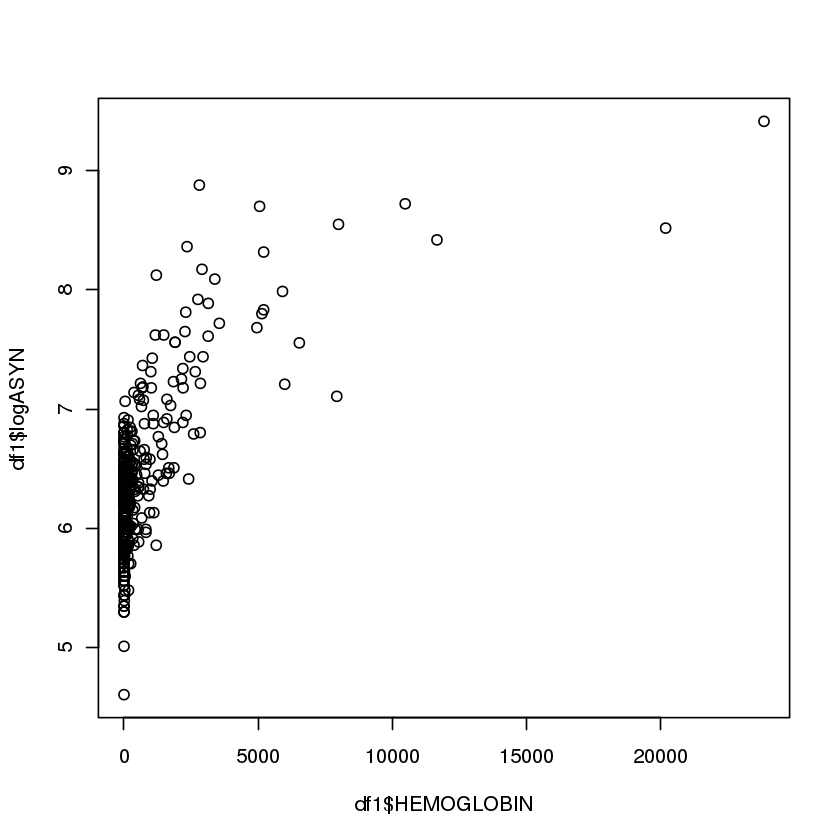

In [4]:
# Alpha Synuc
df=fread("../ADNI/180831/CSFALPHASYN_03_21_14.csv")
df1 = df %>% 
  mutate(DATE=as.Date(EXAMDATE) %>% as.numeric,
         logASYN=log(ALPHA_SYN*1000),
         invnASYN=invNT(ALPHA_SYN*1000),
         rawASYN=ALPHA_SYN*1000)

cat("CSF-HEMOGLOBIN is dominating the log ASYN")
plot(df1$HEMOGLOBIN, df1$logASYN)

HEMOGLOBIN<1200


FALSE  TRUE  <NA> 
   56   333     0 

exclude obs with CSF-HEMOGLOBIN < 1200. But it still seeems to have a strong effect on ALPHA_SYN (below)
looking at variance, filter out obs with large HEMOGLOBIN values.
For the consistency, set the cut-off value at 1200 (PPMI max was 1227)


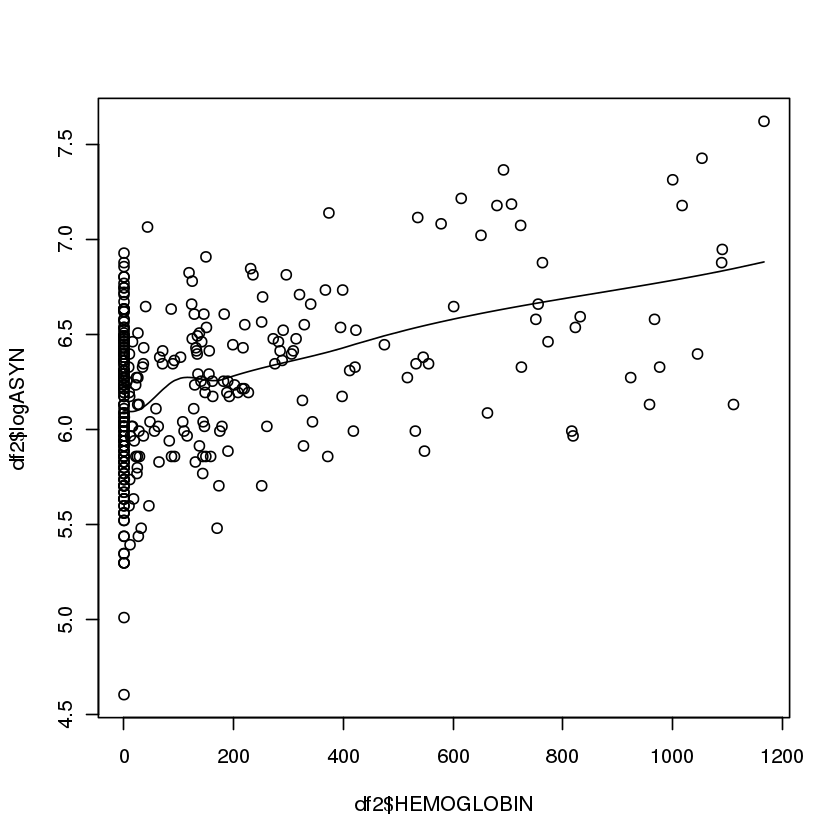

In [5]:
cat("HEMOGLOBIN<1200")
table(df1$HEMOGLOBIN<1200, useNA = "always")
cat("exclude obs with CSF-HEMOGLOBIN < 1200. But it still seeems to have a strong effect on ALPHA_SYN (below)
looking at variance, filter out obs with large HEMOGLOBIN values.
For the consistency, set the cut-off value at 1200 (PPMI max was 1227)
")
df2 = df1 %>% 
  filter(HEMOGLOBIN<1200) %>% arrange(HEMOGLOBIN)
plx = predict(loess(df2$logASYN~df2$HEMOGLOBIN), se=T)
plot(df2$HEMOGLOBIN, df2$logASYN)
lines(df2$HEMOGLOBIN, plx$fit)
## Rolling variance
# library(caTools)
# runsd(df2$logASYN, 20) %>% plot(.)
CSF = df1 %>% select(RID, DATE, rawASYN, logASYN, invnASYN, BOX, HEMOGLOBIN)

In [6]:
CSF %>% summary

      RID              DATE          rawASYN           logASYN     
 Min.   :   3.0   Min.   :13033   Min.   :  100.0   Min.   :4.605  
 1st Qu.: 312.0   1st Qu.:13270   1st Qu.:  400.0   1st Qu.:5.991  
 Median : 621.0   Median :13371   Median :  550.0   Median :6.310  
 Mean   : 653.3   Mean   :13376   Mean   :  798.7   Mean   :6.395  
 3rd Qu.:1002.0   3rd Qu.:13489   3rd Qu.:  750.0   3rd Qu.:6.620  
 Max.   :1423.0   Max.   :13774   Max.   :12240.0   Max.   :9.412  
    invnASYN              BOX              HEMOGLOBIN      
 Min.   :-3.0148936   Length:389         Min.   :    0.00  
 1st Qu.:-0.6524067   Class :character   1st Qu.:    0.00  
 Median :-0.0128879   Mode  :character   Median :   45.44  
 Mean   : 0.0001827                      Mean   :  684.78  
 3rd Qu.: 0.6805695                      3rd Qu.:  411.49  
 Max.   : 3.0148936                      Max.   :23870.60  

In [58]:
# DIAGNOSIS
dx_tmp = fread("../ADNI/180831/DXSUM_PDXCONV_ADNIALL.csv") 
#  summary(dx_tmp)

cat("Summary of Data
DXCURREN 1 normal, 2 MCI, 3 AD. 
DXCHANGE 1 unchange NC, 2 unchange MCI, 3 Unchange AD, 4 NC to MCI, 5 MCI to AD 6 NCI to AD, 7 MCI to NC, 8 AD to MCI 9 AD to NC
either DXCURREN or DXCHANGE were recoreded ")
dx_tmp %>% with(table(DXCURREN, DXCHANGE, useNA = "always"))
dx_tmp %>% with(table(VISCODE2, DXCURREN, useNA = "always"))
dx_tmp %>% with(table(VISCODE2, DXCHANGE, useNA = "always"))
cat("Recode diagnosis DX = 0 HC, 1 MCI, and 2 AD. Table is the following")
dx = dx_tmp %>% mutate(DX = case_when(
  DXCURREN==1 ~ 0,
  DXCURREN==2 ~ 1,
  DXCURREN==3 ~ 2,
  DXCHANGE %in% c(1,7,9) ~ 0,
  DXCHANGE %in% c(2,4,8) ~ 1,
  DXCHANGE %in% c(3,5,6) ~ 2))
dx %>% 
  with(table(VISCODE2,DX,useNA = 'always'))

cat("Individuals with DX=NA at the screening keep DX=NA in the following obs")
RIDtmp = dx %>% filter(VISCODE2=="sc" & is.na(DX)) %>% distinct(RID) %>% t %>% as.vector
dx %>% filter(RID %in% RIDtmp) %>% 
  with(table(VISCODE2, DX, useNA = 'always'))
cat("Similarly, DX=NA at the baseline")
RIDtmp = dx %>% filter(VISCODE2=="bl" & is.na(DX)) %>% distinct(RID) %>% t %>% as.vector
dx %>% filter(RID %in% RIDtmp) %>% 
  with(table(VISCODE2,DX,useNA = 'always'))
cat("DX=NA at the 72nd month. Indicates, DX==NA in a newer observation. NAs seem to be given for unconfirmed\n
    exclude obs with DX=NA from the analysis set")
RIDtmp = dx %>% filter(VISCODE2=="m72" & is.na(DX)) %>% distinct(RID) %>% t %>% as.vector
dx %>% filter(RID %in% RIDtmp) %>% 
  with(table(VISCODE2,DX,useNA = 'always'))
dx = dx %>% filter(!is.na(DX))


cat("Some data tables to understand data\n
DXNORM is the same as DXCURREN==1")
dx %>% with(table(DXCURREN, DXNORM, useNA = "always"))
cat("Depression is only recoreded for DXCURREN")
dx %>% with(table(DXCURREN, DXNODEP, useNA = "always"))
cat("Among MCI, some are MCI not by AD (DXMDUE==2)")
dx %>% with(table(DX, DXMDUE, useNA = "always"))
cat("The reason for MCI due to non AD etiology
1=Fronto-temporal Dementia; 2=Parkinson's Disease; 3=Huntington's Disease; 
4=Progressive Supranuclear Palsy; 5=Alcohol-related Dementia; 6=NPH; 
7=Major Depression; 8=Corticobasal Degeneration; 9=Vascular Dementia; 
10=Prion-Associated Dementia; 11=HIV; 12=Primary Progressive Aphasia; 
13=Posterior Cortical Dysfunction; 14=Other
Individuals reported with MCI with other etiology will be excluded")
dx %>% with(table(DX, DXMOTHET, useNA = "always"))
RIDtmp = dx %>% filter(DXMOTHET!=-4) %>% distinct(RID) %>% t %>% as.vector
dx = dx %>%  filter(!(RID %in% RIDtmp)) 

cat("Diagnostic certaintly of AD 1:Probable, 2:Possible")
dx %>% with(table(DX, DXAPP, useNA = "always"))
cat("Severity of AD 1:Mild, 2:Moderate, 3:Severe")
dx %>% with(table(DX, DXADES, useNA = "always")) # 


cat("The difference between diagnosis at first and last observation")
dx = dx %>% 
  mutate(DATE=as.numeric(as.Date(EXAMDATE))) %>% 
  arrange(RID, DATE)
dx1 = dx %>% group_by(RID) %>% mutate(CHANGE = last(DX) - first(DX))
dx1 %>% distinct(RID, .keep_all = T) %>% with(table(DX, CHANGE, useNA = "always"))
DX = dx %>% group_by(RID) %>% mutate(DXfirst = first(DX), DXlast = last(DX)) %>% ungroup %>% 
  select(Phase, RID, VISCODE2, DATE, DX, DXfirst, DXlast)

Summary of Data
DXCURREN 1 normal, 2 MCI, 3 AD. 
DXCHANGE 1 unchange NC, 2 unchange MCI, 3 Unchange AD, 4 NC to MCI, 5 MCI to AD 6 NCI to AD, 7 MCI to NC, 8 AD to MCI 9 AD to NC
either DXCURREN or DXCHANGE were recoreded 

        DXCHANGE
DXCURREN    1    2    3    4    5    6    7    8 <NA>
    1       0    0    0    0    0    0    0    0 1130
    2       0    0    0    0    0    0    0    0 1606
    3       0    0    0    0    0    0    0    0 1132
    <NA> 1977 2816  972   89  192    1   58    7 1120

        DXCURREN
VISCODE2    1    2    3 <NA>
            0    0    0    1
    bl    229  397  193 1188
    m06   226  354  201  835
    m108    0    0    0   98
    m12   216  291  225  753
    m120    0    0    0   71
    m132    0    0    0   52
    m144    0    0    0   21
    m18    10  226   93    0
    m24   210  180  255  651
    m36   183  139  128  368
    m48    55   19   37  560
    m60     0    0    0  400
    m72     0    0    0  370
    m84     0    0    0  213
    m96     0    0    0  134
    sc      0    0    0 1517
    uns1    1    0    0    0
    <NA>    0    0    0    0

        DXCHANGE
VISCODE2    1    2    3    4    5    6    7    8 <NA>
            0    0    0    0    0    0    0    0    1
    bl    292  468  148    1    0    0    2    0 1096
    m06   263  403  130   11   24    0    4    0  781
    m108   31   33   23    2    8    0    1    0    0
    m12   194  383  125    6   22    0   17    0  738
    m120   23   15   11    5    5    0    2    1    9
    m132    0    0    0    1    0    0    0    0   51
    m144    0    0    0    0    0    0    0    0   21
    m18     0    0    0    0    0    0    0    0  329
    m24   233  300   56   13   41    0    6    2  645
    m36    41  241   44    4   26    0   10    1  451
    m48   166  217   74   15   26    0    9    2  162
    m60   106  130   69    8   11    0    3    1   72
    m72    95   69   50    7   12    0    2    0  135
    m84    72   56   35   12    4    1    0    0   33
    m96    48   44   21    4   13    0    2    0    2
    sc    413  457  186    0    0    0    0    0  461
    uns1   

Recode diagnosis DX = 0 HC, 1 MCI, and 2 AD. Table is the following

        DX
VISCODE2   0   1   2 <NA>
           0   0   0    1
    bl   523 866 341  277
    m06  493 768 355    0
    m108  32  35  31    0
    m12  427 680 372    6
    m120  25  21  16    9
    m132   0   1   0   51
    m144   0   0   0   21
    m18   10 226  93    0
    m24  449 495 352    0
    m36  234 385 198    1
    m48  230 253 137   51
    m60  109 139  80   72
    m72   97  76  62  135
    m84   72  68  40   33
    m96   50  48  34    2
    sc   413 457 186  461
    uns1   1   0   0    0
    <NA>   0   0   0    0

Individuals with DX=NA at the screening keep DX=NA in the following obs

        DX
VISCODE2 <NA>
    bl    276
    m12     6
    sc    461
    <NA>    0

Similarly, DX=NA at the baseline

        DX
VISCODE2 <NA>
    bl    277
    m12     6
    sc    276
    <NA>    0

DX=NA at the 72nd month. Indicates, DX==NA in a newer observation. NAs seem to be given for unconfirmed

    exclude obs with DX=NA from the analysis set

        DX
VISCODE2   0   1   2 <NA>
    bl    65  70   0    0
    m06   62  65   3    0
    m12   66  63   3    0
    m24   63  58   9    0
    m36   15  52  10    0
    m48   54  51   9    1
    m60    2  22   2   10
    m72    0   0   0  135
    m84    0   0   0   11
    sc    65  53   0    0
    <NA>   0   0   0    0

Some data tables to understand data

DXNORM is the same as DXCURREN==1

        DXNORM
DXCURREN   -4    1 <NA>
    1       0 1130    0
    2    1606    0    0
    3    1132    0    0
    <NA>    0    0 6112

Depression is only recoreded for DXCURREN

        DXNODEP
DXCURREN   -4    1 <NA>
    1    1115   15    0
    2    1556   50    0
    3    1112   20    0
    <NA>    0    0 6112

Among MCI, some are MCI not by AD (DXMDUE==2)

      DXMDUE
DX       -4    1    2 <NA>
  0    1130    0    0 2035
  1       5 4290  223    0
  2    1132    0    0 1165
  <NA>    0    0    0    0

The reason for MCI due to non AD etiology
1=Fronto-temporal Dementia; 2=Parkinson's Disease; 3=Huntington's Disease; 
4=Progressive Supranuclear Palsy; 5=Alcohol-related Dementia; 6=NPH; 
7=Major Depression; 8=Corticobasal Degeneration; 9=Vascular Dementia; 
10=Prion-Associated Dementia; 11=HIV; 12=Primary Progressive Aphasia; 
13=Posterior Cortical Dysfunction; 14=Other
Individuals reported with MCI with other etiology will be excluded

      DXMOTHET
DX       -4    1   14    2 2:14    4    6 6:08    7  7:9    8    9 9:14 <NA>
  0    3165    0    0    0    0    0    0    0    0    0    0    0    0    0
  1    4295    9  108    3    2    1   16    1    9    1   50   21    2    0
  2    2297    0    0    0    0    0    0    0    0    0    0    0    0    0
  <NA>    0    0    0    0    0    0    0    0    0    0    0    0    0    0

Diagnostic certaintly of AD 1:Probable, 2:Possible

      DXAPP
DX       -4    1    2 <NA>
  0    1074    0    0 2008
  1    1397    0    0 2616
  2       3 2150   61   15
  <NA>    0    0    0    0

Severity of AD 1:Mild, 2:Moderate, 3:Severe

      DXADES
DX       -4    1    2    3 <NA>
  0    1074    0    0    0 2008
  1    1397    0    0    0 2616
  2       3  869  209   20 1128
  <NA>    0    0    0    0    0

The difference between diagnosis at first and last observation

      CHANGE
DX      -1   0   1   2 <NA>
  0      0 553  51  24    0
  1     43 559 291   0    0
  2      2 376   0   0    0
  <NA>   0   0   0   0    0

In [72]:
# Join the data
temp = inner_join(DEMO, CSF, by="RID") %>% 
  left_join(., DX, by=c("RID")) %>% # duplicated obs for DATE
  arrange(RID, DATE.y) %>% 
  group_by(RID) %>% 
  filter(DATE.x <= DATE.y) %>% 
  distinct(RID, .keep_all = T) %>% # keep the latest diagnosis after CSF sampling
  ungroup
DF = temp %>% 
  mutate(AGE=(DATE.x-DOB)/365.25,
         DATASET="ADNI",
         IID=RID) %>% 
  filter(HEMOGLOBIN<1200) %>% 
  select("DATASET", "IID","rawASYN", "logASYN", "invnASYN", "DX", "FEMALE","YEARSEDUC", "HEMOGLOBIN", "AGE", "DXfirst", "DXlast", "BOX")
cat("summary of the final data
NOTE: excluded HEMOGLOBIN>1200")
summary(DF)
cat("full model")
lm(logASYN~FEMALE+AGE+HEMOGLOBIN+YEARSEDUC+as.factor(BOX)+as.factor(DX), DF) %>% summary
cat("\n\nReplacing DX with the latest DX and this has better prediction. Use the latest DX.")
lm(logASYN~FEMALE+AGE+HEMOGLOBIN+YEARSEDUC+as.factor(BOX)+as.factor(DXlast), DF) %>% summary

cat("\nWhen comparing tha above model vs the above model excluding the Box term, 
the former has significantly better prediction.")
anova(lm(logASYN~FEMALE+AGE+HEMOGLOBIN+YEARSEDUC+as.factor(BOX)+as.factor(DXlast), DF),
      lm(logASYN~FEMALE+AGE+HEMOGLOBIN+YEARSEDUC+as.factor(DXlast), DF))

cat("\n\nThe boxes seem to group as 1,2,4 and 3,5. 
This is the best model (might be overfitting). PCs will be added later and decide the final model")
lm(logASYN~FEMALE+AGE+HEMOGLOBIN+YEARSEDUC+I(BOX=="Box 5" | BOX=="Box 3") + as.factor(DXlast), DF) %>% summary

summary of the final data
NOTE: excluded HEMOGLOBIN>1200

   DATASET               IID            rawASYN          logASYN       
 Length:301         Min.   :   3.0   Min.   :0.1000   Min.   :-2.3026  
 Class :character   1st Qu.: 319.0   1st Qu.:0.3800   1st Qu.:-0.9676  
 Mode  :character   Median : 626.0   Median :0.5200   Median :-0.6539  
                    Mean   : 655.9   Mean   :0.5478   Mean   :-0.6891  
                    3rd Qu.:1013.0   3rd Qu.:0.6500   3rd Qu.:-0.4308  
                    Max.   :1423.0   Max.   :1.6800   Max.   : 0.5188  
    invnASYN             DX             FEMALE        YEARSEDUC    
 Min.   :-3.0149   Min.   :0.0000   Min.   :0.000   Min.   : 6.00  
 1st Qu.:-0.7816   1st Qu.:0.0000   1st Qu.:0.000   1st Qu.:14.00  
 Median :-0.1488   Median :1.0000   Median :0.000   Median :16.00  
 Mean   :-0.2293   Mean   :0.9834   Mean   :0.402   Mean   :15.57  
 3rd Qu.: 0.4213   3rd Qu.:2.0000   3rd Qu.:1.000   3rd Qu.:18.00  
 Max.   : 1.4337   Max.   :2.0000   Max.   :1.000   Max.   :20.00  
   HEMOGLOBIN       

full model


Call:
lm(formula = logASYN ~ FEMALE + AGE + HEMOGLOBIN + YEARSEDUC + 
    as.factor(BOX) + as.factor(DX), data = DF)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2775 -0.2310  0.0185  0.2551  0.8870 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -1.2229967  0.2702916  -4.525 8.83e-06 ***
FEMALE               0.0172377  0.0440422   0.391   0.6958    
AGE                  0.0051252  0.0029755   1.722   0.0861 .  
HEMOGLOBIN           0.0006673  0.0000822   8.118 1.37e-14 ***
YEARSEDUC           -0.0112526  0.0071294  -1.578   0.1156    
as.factor(BOX)Box 2 -0.0257328  0.0682648  -0.377   0.7065    
as.factor(BOX)Box 3  0.1258570  0.0664429   1.894   0.0592 .  
as.factor(BOX)Box 4 -0.0186601  0.0667511  -0.280   0.7800    
as.factor(BOX)Box 5  0.1321308  0.0660056   2.002   0.0462 *  
as.factor(DX)1       0.2227098  0.0501474   4.441 1.27e-05 ***
as.factor(DX)2       0.2770634  0.0554239   4.999 9.99e-07 ***
---
Signif. codes



Replacing DX with the latest DX and this has better prediction. Use the latest DX.


Call:
lm(formula = logASYN ~ FEMALE + AGE + HEMOGLOBIN + YEARSEDUC + 
    as.factor(BOX) + as.factor(DXlast), data = DF)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2426 -0.2234  0.0241  0.2454  0.8850 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -1.229e+00  2.681e-01  -4.586 6.72e-06 ***
FEMALE               1.638e-02  4.343e-02   0.377   0.7063    
AGE                  4.706e-03  2.954e-03   1.593   0.1122    
HEMOGLOBIN           6.574e-04  8.165e-05   8.052 2.13e-14 ***
YEARSEDUC           -1.159e-02  7.072e-03  -1.638   0.1025    
as.factor(BOX)Box 2 -2.358e-02  6.782e-02  -0.348   0.7283    
as.factor(BOX)Box 3  1.261e-01  6.601e-02   1.910   0.0571 .  
as.factor(BOX)Box 4 -3.357e-02  6.649e-02  -0.505   0.6140    
as.factor(BOX)Box 5  1.124e-01  6.565e-02   1.712   0.0880 .  
as.factor(DXlast)1   2.686e-01  6.171e-02   4.352 1.87e-05 ***
as.factor(DXlast)2   2.961e-01  5.225e-02   5.668 3.49e-08 ***
---
Signif. c


When comparing tha above model vs the above model except for the Box term, 
the former has significantly better prediction.

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
290,36.62973,NA,NA,NA,NA
294,38.03846,-4,-1.408731,2.788254,0.02677328




The boxes seem to group as 1,2,4 and 3,5. 
This is the best model (might be overfitting). PCs will be added later and decide the final model


Call:
lm(formula = logASYN ~ FEMALE + AGE + HEMOGLOBIN + YEARSEDUC + 
    I(BOX == "Box 5" | BOX == "Box 3") + as.factor(DXlast), data = DF)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.24709 -0.22863  0.01974  0.25629  0.88271 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                            -1.259e+00  2.588e-01  -4.864 1.88e-06
FEMALE                                  1.533e-02  4.302e-02   0.356  0.72180
AGE                                     4.802e-03  2.917e-03   1.646  0.10076
HEMOGLOBIN                              6.611e-04  8.099e-05   8.163 9.80e-15
YEARSEDUC                              -1.136e-02  7.014e-03  -1.620  0.10636
I(BOX == "Box 5" | BOX == "Box 3")TRUE  1.386e-01  4.189e-02   3.308  0.00106
as.factor(DXlast)1                      2.680e-01  6.139e-02   4.365 1.77e-05
as.factor(DXlast)2                      2.943e-01  5.177e-02   5.684 3.17e-08
                                     